# SHO Fitting Data

## Import Packages

In [1]:
import sys
sys.path.append('../../')
sys.path.append('/home/ferroelectric/m3_learning/m3_learning/src')

In [2]:
%load_ext autoreload
# import gdown
import time
import h5py
import pyUSID as usid
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import style
from m3_learning.be.util import print_be_tree
from m3_learning.be.processing import convert_amp_phase, fit_loop_function, SHO_Fitter, SHO_fit_to_array, loop_lsqf
from m3_learning.viz.layout import layout_fig
from m3_learning.util.h5_util import make_dataset, make_group
from m3_learning.util.file_IO import download_and_unzip
from m3_learning.viz.printing import printer
printing = printer(basepath = './figures/')

from scipy.signal import resample
from scipy import fftpack


style("default")
random_seed(seed=42)

%matplotlib inline


2023-03-27 16:42:46.849977: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 16:42:46.968204: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-27 16:42:47.401670: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-27 16:42:47.401718: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

default set for matplotlib
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


## Loading data for SHO fitting


In [3]:
path = r"./"

In [4]:
# Download the data file from Zenodo
url = 'https://zenodo.org/record/7774788/files/PZT_2080_raw_data.h5?download=1'

# Specify the filename and the path to save the file
filename = 'data_file_raw.h5'
save_path = './'

# download the file
download_and_unzip(filename, url, save_path)

Using files already downloaded


In [142]:
from m3_learning.util.h5_util import print_tree
from BGlib import be as belib
import pyUSID as usid
import os
import sidpy
import numpy as np

class BE_Dataset:
    
    def __init__(self, dataset):
        
        self.dataset = dataset
        
    def print_be_tree(self):
        """Utility file to print the Tree of a BE Dataset

        Args:
            path (str): path to the h5 file
        """
        
        with h5py.File(self.dataset, "r+") as h5_f:

            # Inspects the h5 file
            usid.hdf_utils.print_tree(h5_f)

            # prints the structure and content of the file
            print("Datasets and datagroups within the file:\n------------------------------------")
            print_tree(h5_f.file)

            print("\nThe main dataset:\n------------------------------------")
            print(h5_f)
            print("\nThe ancillary datasets:\n------------------------------------")
            print(h5_f.file["/Measurement_000/Channel_000/Position_Indices"])
            print(h5_f.file["/Measurement_000/Channel_000/Position_Values"])
            print(h5_f.file["/Measurement_000/Channel_000/Spectroscopic_Indices"])
            print(h5_f.file["/Measurement_000/Channel_000/Spectroscopic_Values"])

            print("\nMetadata or attributes in a datagroup\n------------------------------------")
            for key in h5_f.file["/Measurement_000"].attrs:
                print("{} : {}".format(key, h5_f.file["/Measurement_000"].attrs[key]))
                
    def SHO_Fitter(self, force=False, max_cores=-1, max_mem=1024*8):
        """Function that computes the SHO fit results

        Args:
            force (bool, optional): forces the SHO results to be computed from scratch. Defaults to False.
            max_cores (int, optional): number of processor cores to use. Defaults to -1.
            max_mem (_type_, optional): maximum ram to use. Defaults to 1024*8.
        """

        start_time_lsqf = time.time()

        (data_dir, filename) = os.path.split(self.dataset)

        if self.dataset.endswith(".h5"):
            # No translation here
            h5_path = self.dataset

            tl = belib.translators.LabViewH5Patcher()
            tl.translate(h5_path, force_patch=force)

        else:
            pass

        folder_path, h5_raw_file_name = os.path.split(h5_path)
        h5_file = h5py.File(h5_path, "r+")
        print("Working on:\n" + h5_path)

        h5_main = usid.hdf_utils.find_dataset(h5_file, "Raw_Data")[0]

        h5_pos_inds = h5_main.h5_pos_inds
        pos_dims = h5_main.pos_dim_sizes
        pos_labels = h5_main.pos_dim_labels
        print(pos_labels, pos_dims)

        h5_meas_grp = h5_main.parent.parent

        parm_dict = sidpy.hdf_utils.get_attributes(h5_meas_grp)

        expt_type = usid.hdf_utils.get_attr(h5_file, "data_type")

        is_ckpfm = expt_type == "cKPFMData"
        if is_ckpfm:
            num_write_steps = parm_dict["VS_num_DC_write_steps"]
            num_read_steps = parm_dict["VS_num_read_steps"]
            num_fields = 2

        if expt_type != "BELineData":
            vs_mode = usid.hdf_utils.get_attr(h5_meas_grp, "VS_mode")
            try:
                field_mode = usid.hdf_utils.get_attr(
                    h5_meas_grp, "VS_measure_in_field_loops")
            except KeyError:
                print("field mode could not be found. Setting to default value")
                field_mode = "out-of-field"
            try:
                vs_cycle_frac = usid.hdf_utils.get_attr(
                    h5_meas_grp, "VS_cycle_fraction")
            except KeyError:
                print("VS cycle fraction could not be found. Setting to default value")
                vs_cycle_frac = "full"

        sho_fit_points = 5  # The number of data points at each step to use when fitting
        sho_override = force  # Force recompute if True

        h5_sho_targ_grp = None
        h5_sho_file_path = os.path.join(
            folder_path, h5_raw_file_name)

        print("\n\nSHO Fits will be written to:\n" + h5_sho_file_path + "\n\n")
        f_open_mode = "w"
        if os.path.exists(h5_sho_file_path):
            f_open_mode = "r+"
        h5_sho_file = h5py.File(h5_sho_file_path, mode=f_open_mode)
        h5_sho_targ_grp = h5_sho_file

        sho_fitter = belib.analysis.BESHOfitter(
            h5_main, cores=max_cores, verbose=False, h5_target_group=h5_sho_targ_grp
        )
        sho_fitter.set_up_guess(
            guess_func=belib.analysis.be_sho_fitter.SHOGuessFunc.complex_gaussian,
            num_points=sho_fit_points,
        )
        h5_sho_guess = sho_fitter.do_guess(override=sho_override)
        sho_fitter.set_up_fit()
        h5_sho_fit = sho_fitter.do_fit(override=sho_override)
        parms_dict = parms_dict = sidpy.hdf_utils.get_attributes(
            h5_main.parent.parent)

        print(
            f"LSQF method took {time.time() - start_time_lsqf} seconds to compute parameters")
    
    @property
    def be_repeats(self):
        """Number of BE repeats"""
        with h5py.File(self.dataset, "r") as h5_f:
            return h5_f['Measurement_000'].attrs["BE_repeats"]
        
    @property
    def num_bins(self):
        """Number of frequency bins in the data"""
        with h5py.File(self.dataset, "r") as h5_f:
            return h5_f["Measurement_000"].attrs["num_bins"]
    
    @property
    def num_pix(self):
        """Number of pixels in the data"""
        with h5py.File(self.dataset, "r") as h5_f:
            return h5_f["Measurement_000"].attrs["num_pix"]
    
    @property
    def num_pix_1d(self):
        """Number of pixels in the data"""
        with h5py.File(self.dataset, "r") as h5_f:
            return int(np.sqrt(self.num_pix))
    
    @property
    def voltage_steps(self):
        """Number of DC voltage steps"""
        with h5py.File(self.dataset, "r") as h5_f:
            return h5_f["Measurement_000"].attrs["num_udvs_steps"]

    @property
    def sampling_rate(self):
        """Sampling rate in Hz"""
        with h5py.File(self.dataset, "r") as h5_f:
            return h5_f["Measurement_000"].attrs["IO_rate_[Hz]"]
        
    @property
    def be_bandwidth(self):
        """BE bandwidth in Hz"""
        with h5py.File(self.dataset, "r") as h5_f:
            return h5_f["Measurement_000"].attrs["BE_band_width_[Hz]"]

    @property
    def be_center_frequency(self):
        """BE center frequency in Hz"""
        with h5py.File(self.dataset, "r") as h5_f:
            return h5_f["Measurement_000"].attrs["BE_center_frequency_[Hz]"]
        
    @property
    def frequency_bin(self):
        """Frequency bin vector in Hz"""
        with h5py.File(self.dataset, "r") as h5_f:
            return h5_f["Measurement_000"]["Channel_000"]["Bin_Frequencies"][:]
        
    @property
    def wvec_freq(self, bins = 80):
        """Resampled frequency vector in Hz"""
        with h5py.File(self.dataset, "r") as h5_f:
            try:
                return self._wvec_freq
            except:
                self.wvec_freq = bins
                return self._wvec_freq

    @wvec_freq.setter
    def wvec_freq(self, bins):
        self._wvec_freq = resample(self.frequency_bin, bins)
        
    @property
    def be_waveform(self):
        """BE excitation waveform"""
        with h5py.File(self.dataset, "r") as h5_f:
            return h5_f["Measurement_000"]["Channel_000"]["Excitation_Waveform"][:]
        
    @property
    def spectroscopic_values(self):
        """Spectroscopic values"""
        with h5py.File(self.dataset, "r") as h5_f:
            return h5_f["Measurement_000"]["Channel_000"]["Spectroscopic_Values"][:]
        
    @property
    def raw_data(self):
        """Raw data"""
        with h5py.File(self.dataset, "r") as h5_f:
            return h5_f["Measurement_000"]["Channel_000"]["Raw_Data"][:]
        
        
    @property
    def shape(self):
        """Shape of the raw data"""
        with h5py.File(self.dataset, "r") as h5_f:
            return self.raw_data.shape
        
    @property
    def complex_spectrum(self):
        """Complex data"""
        with h5py.File(self.dataset, "r+") as h5_f:
            try:
                return self._complex_spectrum
            except:
                self.complex_spectrum = None
                return self._complex_spectrum
                
    @complex_spectrum.setter
    def complex_spectrum(self, a = None):
        with h5py.File(self.dataset, "r+") as h5_f:
            try: 
                self._complex_spectrum = h5_f["Measurement_000"]["Channel_000"]['complex']
            except:
                make_group(h5_f["Measurement_000"]["Channel_000"], 'complex')
                make_dataset(h5_f["Measurement_000"]["Channel_000"]['complex'], 'real', np.real(self.raw_data))
                make_dataset(h5_f["Measurement_000"]["Channel_000"]['complex'], 'imag', np.imag(self.raw_data))
                self._complex_spectrum = h5_f["Measurement_000"]["Channel_000"]['complex']
                
    @property
    def complex_spectrum_real(self):
        """Real part of the complex data"""
        with h5py.File(self.dataset, "r+") as h5_f:
            return h5_f["Measurement_000"]["Channel_000"]['complex']['real'][:]
        
    @property
    def complex_spectrum_imag(self):
        """Imaginary part of the complex data"""
        with h5py.File(self.dataset, "r+") as h5_f:
            return h5_f["Measurement_000"]["Channel_000"]['complex']['imag'][:]
        
    @property
    def magnitude_spectrum(self):
        with h5py.File(self.dataset, "r+") as h5_f:
            try:
                return self._magnitude_spectrum
            except:
                self.magnitude_spectrum = None
                return self._magnitude_spectrum
            
    @magnitude_spectrum.setter
    def magnitude_spectrum(self, a = None):
        with h5py.File(self.dataset, "r+") as h5_f:
            try: 
                self._magnitude_spectrum = h5_f["Measurement_000"]["Channel_000"]['magnitude_spectrum']
            except:
                make_group(h5_f["Measurement_000"]["Channel_000"], 'magnitude_spectrum')
                make_dataset(h5_f["Measurement_000"]["Channel_000"]['magnitude_spectrum'], 'amplitude', np.abs(
                    self.raw_data))
                make_dataset(h5_f["Measurement_000"]["Channel_000"]['magnitude_spectrum'], 'phase', np.angle(
                    self.raw_data))
                self._magnitude_spectrum = h5_f["Measurement_000"]["Channel_000"]['magnitude_spectrum']
    
    @property
    def magnitude_spectrum_amplitude(self):
        with h5py.File(self.dataset, "r+") as h5_f:
            return h5_f["Measurement_000"]["Channel_000"]['magnitude_spectrum']['amplitude'][:]
    
    @property
    def magnitude_spectrum_phase(self):
        with h5py.File(self.dataset, "r+") as h5_f:
            return h5_f["Measurement_000"]["Channel_000"]['magnitude_spectrum']['phase'][:]
         
    def get_spectra(self, data, pixels, timestep):
        """Spectra"""
        with h5py.File(self.dataset, "r") as h5_f:
            return data.reshape(self.num_pix, -1, self.num_bins)[pixel, timestep]
            
    @property
    def hysteresis_waveform(self, loop_number = 2):
        with h5py.File(self.dataset, "r") as h5_f:
            return (
                self.spectroscopic_values[1, ::len(self.frequency_bin)][int(self.voltage_steps/loop_number):] *
                self.spectroscopic_values[2, ::len(
                    self.frequency_bin)][int(self.voltage_steps/loop_number):]
            )


In [143]:
len(dataset.frequency_bin)
dataset.voltage_steps/2


192.0

Prints the Tree to show the Data Structure

In [144]:
# instantiate the dataset object
dataset = BE_Dataset(path + "data_file_raw.h5")

# print the contents of the file
dataset.print_be_tree()

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices
    ├ amplitude_phase
      ---------------
      ├ amplitude
      ├ phase
    ├ complex
      -------
      ├ imag
      ├ real
    ├ magnitude_spectrum
      ------------------
     

## SHO Fitting
**Note**: this code takes around 15 minutes to execute

In [145]:
# # computes the SHO fit for the data in the file
# dataset.SHO_Fitter()

### Saves the Data

In [146]:
dataset.complex_spectrum
dataset.magnitude_spectrum

<Closed HDF5 group>

In [147]:
with h5py.File(dataset.dataset, "r+") as h5_f:
    print()
    

In [148]:
dataset.be_repeats


4

### Visualize Raw Data

646 20
Number of time steps: 4096.0


/home/ferroelectric/anaconda3/envs/rapidfitting/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


./figures/Figure_1_random_cantilever_resonance_results.png
./figures/Figure_1_random_cantilever_resonance_results.svg


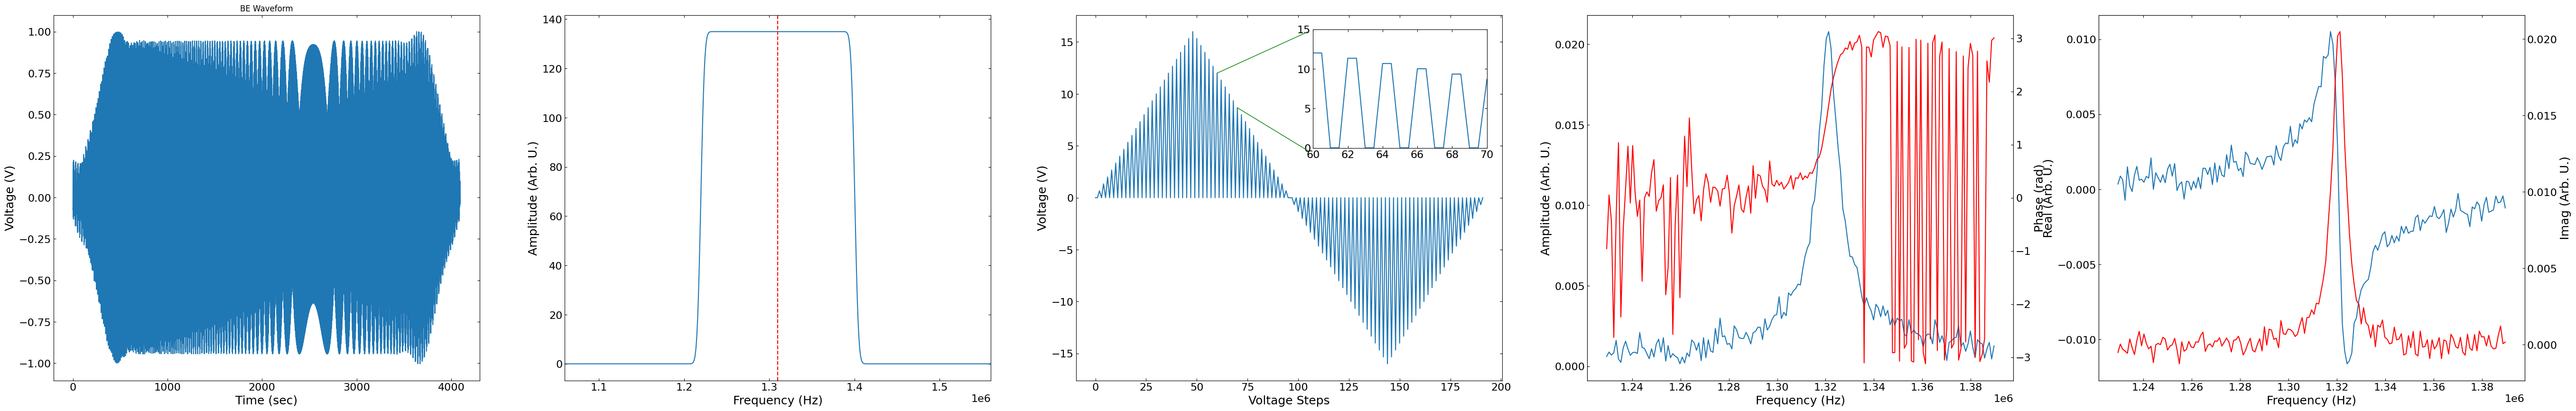

In [149]:
# Select a random point and time step to plot
pixel = np.random.randint(0, dataset.num_pix)
timestep = np.random.randint(dataset.voltage_steps)

print(pixel, timestep)

# Plots the amplitude and phase for the selected pixel and time step
fig, ax = layout_fig(5, 5, figsize=(6 * 11.2, 10))

# constructs the BE waveform and plot
be_timesteps = len(dataset.be_waveform) / dataset.be_repeats


print("Number of time steps: " + str(be_timesteps))
ax[0].plot(dataset.be_waveform[: int(be_timesteps)])
ax[0].set(xlabel="Time (sec)", ylabel="Voltage (V)")
ax[0].set_title("BE Waveform")

# plots the resonance graph
resonance_graph = np.fft.fft(dataset.be_waveform[: int(be_timesteps)])
fftfreq = fftpack.fftfreq(int(be_timesteps)) * dataset.sampling_rate

ax[1].plot(
    fftfreq[: int(be_timesteps) //
            2], np.abs(resonance_graph[: int(be_timesteps) // 2])
)

ax[1].axvline(
    x=dataset.be_center_frequency,
    ymax=np.max(resonance_graph[: int(be_timesteps) // 2]),
    linestyle="--",
    color="r",
)

ax[1].set(xlabel="Frequency (Hz)", ylabel="Amplitude (Arb. U.)")

ax[1].set_xlim(
    dataset.be_center_frequency - dataset.be_bandwidth - dataset.be_bandwidth * 0.25,
    dataset.be_center_frequency + dataset.be_bandwidth + dataset.be_bandwidth * 0.25,
)

# manually set the x limits
x_start = 120
x_end = 140

ax[2].plot(dataset.hysteresis_waveform)
ax_new = fig.add_axes([0.52, 0.6, 0.3/5.5, 0.25])
ax_new.plot(np.repeat(dataset.hysteresis_waveform, 2))
ax_new.set_xlim(x_start, x_end)
ax_new.set_ylim(0, 15)
ax_new.set_xticks(np.linspace(x_start, x_end, 6))
ax_new.set_xticklabels([60, 62, 64, 66, 68, 70])
fig.add_artist(
    ConnectionPatch(
        xyA=(x_start // 2, dataset.hysteresis_waveform[x_start // 2]),
        coordsA=ax[2].transData,
        xyB=(105, 16),
        coordsB=ax[2].transData,
        color="green",
    )
)
fig.add_artist(
    ConnectionPatch(
        xyA=(x_end // 2, dataset.hysteresis_waveform[x_end // 2]),
        coordsA=ax[2].transData,
        xyB=(105, 4.5),
        coordsB=ax[2].transData,
        color="green",
    )
)
ax[2].set_xlabel("Voltage Steps")
ax[2].set_ylabel("Voltage (V)")

# plots the magnitude spectrum for and phase for the selected pixel and time step
ax[3].plot(
    dataset.frequency_bin,
    dataset.get_spectra(dataset.magnitude_spectrum_amplitude, pixel, timestep),
)
ax[3].set(xlabel="Frequency (Hz)", ylabel="Amplitude (Arb. U.)")
ax2 = ax[3].twinx()
ax2.plot(
    dataset.frequency_bin,
    dataset.get_spectra(dataset.magnitude_spectrum_phase, pixel, timestep),
    "r",
)
ax2.set(xlabel="Frequency (Hz)", ylabel="Phase (rad)")

# plots the real and imaginary components for the selected pixel and time step
ax[4].plot(dataset.frequency_bin, dataset.get_spectra(
    dataset.complex_spectrum_real, pixel, timestep), label="Real")
ax[4].set(xlabel="Frequency (Hz)", ylabel="Real (Arb. U.)")
ax3 = ax[4].twinx()
ax3.plot(
    dataset.frequency_bin, dataset.get_spectra(
        dataset.complex_spectrum_imag, pixel, timestep), 'r', label="Imaginary")
ax3.set(xlabel="Frequency (Hz)", ylabel="Imag (Arb. U.)")

printing.savefig(
    fig, "Figure_1_random_cantilever_resonance_results", tight_layout=False)


### Plots the SHO Fit Results

In [ ]:
# extracts the dc voltage values this removes the 0 values which are measurement points
dc_voltage = h5_f["Measurement_000"]["Channel_000"]['Raw_Data-SHO_Fit_000']['Spectroscopic_Values'][0,1::2]

# extracts the SHO fit results
SHO_fit_results = SHO_fit_to_array(h5_f["Measurement_000"]["Channel_000"]["Raw_Data-SHO_Fit_000"]["Fit"])

In [ ]:
# selects a random pixel to plot
pix = np.random.randint(0,3600)

# plots the SHO fit results for the selected pixel
figs, ax = layout_fig(4, 4, figsize=(30, 6))

# labels for the plots
labels = [{'title': "Amplitude",
            'y_label': "Ampltude (Arb. U.)"},
         {'title': "Resonance Frequency",
            'y_label': "Resonance Frequency (Hz)"},
         {'title': "Dampening",
            'y_label': "Quality Factor (Arb. U.)"},
        {'title': "Phase",
            'y_label': "Phase (rad)"}]

for i, ax in enumerate(ax):
    ax.plot(dc_voltage, SHO_fit_results[pix,1::2,i])
    ax.set_title(labels[i]['title'])
    ax.set_ylabel(labels[i]['y_label'])
    
figs.tight_layout()
printing.savefig(figs, "Figure_2_random_SHO_fit_results")

### Visualize the SHO Fit Results

In [ ]:
# extracts the fit results from an H5 file
fit_results_list = SHO_fit_to_array(h5_f["Measurement_000"]["Channel_000"]["Raw_Data-SHO_Fit_000"]["Fit"])

# flatten parameters list into numpy array
fit_results_list = np.array(fit_results_list).reshape(num_pix, voltage_steps, 5)

In [ ]:
# check distributions of each parameter before and after scaling
fig, axs = layout_fig(4, 4, figsize=(35, 4))

# defines the units for each parameter
units = [
    "Amplitude (Arb. U.)",
    "Frequency (Hz)",
    "Quality Factor (Arb. U.)",
    "Phase (rad)",
]

# plots the distributions of each parameter before scaling
for i in range(4):
    axs[i].hist(fit_results_list[:, :, i].flatten(), 100)


for i, ax in enumerate(axs.flat):
    ax.set(xlabel=units[i], ylabel="Density")
    ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
    
printing.savefig(figs, "Figure_3_SHO_fit_results_before_scaling")

In [ ]:
# Closes the h5_file
h5_f.close()